In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from geopy import geocoders
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from rapidfuzz import fuzz, process 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Data Preparation

In [2]:
#Reading in the London houses data
full_data = pd.read_csv("London.csv")
full_data

,Unnamed: 0,Property Name,Price,House Type,Area in sq ft,No. of Bedrooms,No. of Bathrooms,No. of Receptions,Location,City/County,Postal Code
0,0,Queens Road,1675000,House,2716,5,5,5,Wimbledon,London,SW19 8NY
1,1,Seward Street,650000,Flat / Apartment,814,2,2,2,Clerkenwell,London,EC1V 3PA
2,2,Hotham Road,735000,Flat / Apartment,761,2,2,2,Putney,London,SW15 1QL
3,3,Festing Road,1765000,House,1986,4,4,4,Putney,London,SW15 1LP
4,4,Spencer Walk,675000,Flat / Apartment,700,2,2,2,Putney,London,SW15 1PL
...,...,...,...,...,...,...,...,...,...,...,...
3475,3475,One Lillie Square,3350000,New development,1410,3,3,3,NaN,Lillie Square,SW6 1UE
3476,3476,St. James's Street,5275000,Flat / Apartment,1749,3,3,3,St James's,London,SW1A 1JT
3477,3477,Ingram Avenue,5995000,House,4435,6,6,6,Hampstead Garden Suburb,London,NW11 6TG
3478,3478,Cork Street,6300000,New development,1506,3,3,3,Mayfair,London,W1S 3AR


In [3]:
full_data.isnull().sum()

Unnamed: 0             0
Property Name          0
Price                  0
House Type             0
Area in sq ft          0
No. of Bedrooms        0
No. of Bathrooms       0
No. of Receptions      0
Location             962
City/County            0
Postal Code            0
dtype: int64

## Fuzzymatching 

- In this dataset, there were many missing entries in the Location feature. Dropping them would not make sense as there were too many of the missing entries and would mean a lot of data loss. <br>
- There were also potential wrong entries of post codes in the Postal_Code feature. <br>
- To impute the missing 962 location entries, check and replace incorrect post code entries, the phenomenon of Fuzzymatching was used.<br> 
- This technique is used to identify two string elements that match partially but not exactly and is the same phenomenon used in search engines when we search using wrong spellings but it returns searches with corrected spellings
- Postal codes from a more reliable source data.gov.uk would be used to check for the postal codes in the dataset.

In [10]:
# Reading in the postcode data
postcode_db = pd.read_csv("postal_code_db.csv")
postcode_db

,Postcode,Admin_county_code,Admin_district_code,Admin_ward_code
0,AB101AB,NaN,S12000033,S13002842
1,AB101AF,NaN,S12000033,S13002842
2,AB101AG,NaN,S12000033,S13002842
3,AB101AH,NaN,S12000033,S13002842
4,AB101AL,NaN,S12000033,S13002842
...,...,...,...,...
1719480,ZE3 9JU,NaN,S12000027,S13002776
1719481,ZE3 9JW,NaN,S12000027,S13002776
1719482,ZE3 9JX,NaN,S12000027,S13002776
1719483,ZE3 9JY,NaN,S12000027,S13002776


To make the postcode locations form data.govuk.com more readable, another dataset with codelists and human readable locations had to be used to map the codes from postcode dataset to their human readable formats in the codelist.csv

In [11]:
"""These lines of code read in the postcode database and the codelist first
   When the codebook is read in the index of the code book is changed to the codes list
   and the dataframe is converted to a dictionary with the codes as keys and corresponding values as 
   human_readable_names"""
postcode_db = pd.read_csv("postal_code_db.csv")
codebook = pd.read_csv("codelist.csv")\
    .set_index('code').to_dict()['human_readable_name']

In [12]:
"""Iterating through codebook dictionary and filling in the corresponding Location names from the key postcodes"""
for col in postcode_db.columns[1:]:
    postcode_db[col] = postcode_db[col].apply(lambda x: codebook.get(x, x))
    
postcode_db.sample(10)

,Postcode,Admin_county_code,Admin_district_code,Admin_ward_code
888292,M43 7ER,NaN,Tameside District (B),Droylsden East Ward
326154,CV358TX,Warwickshire County,Warwick District,Budbrooke Ward
564868,G73 5LQ,NaN,South Lanarkshire,Rutherglen South Ward
297002,CR6 9LW,Surrey County,Tandridge District,Warlingham East and Chelsham and Farleigh Ward
1569196,TS134RH,NaN,Redcar and Cleveland (B),Loftus Ward
345332,DA110EJ,Kent County,Gravesham District (B),Pelham Ward
876363,M27 0SW,NaN,Salford District (B),Swinton & Wardley Ward
580331,GL208SY,Gloucestershire County,Tewkesbury District (B),Northway Ward
1276571,S41 8PQ,Derbyshire County,Chesterfield District (B),Moor Ward
384115,DG7 2BA,NaN,Dumfries and Galloway,Dee and Glenkens Ward


In [13]:
postcode_db.shape

(1719485, 4)

In [14]:
"""Finding the valid postal codes in the dataset"""
property_postcode = full_data['Postal Code']

#First letters of codes determine the locations
starting_letters = property_postcode.apply(lambda x: x[0]).unique()


valid_os_postcode = postcode_db['Postcode']
valid_os_postcode = valid_os_postcode[valid_os_postcode.apply(lambda x: x[0]).isin(starting_letters)]
valid_os_postcode

24954      B1  1AY
24955      B1  1BA
24956      B1  1BB
24957      B1  1BD
24958      B1  1BE
            ...   
1700035    WV992GZ
1700036    WV992HA
1700037    WV992HB
1700038    WV992HD
1700039    WV992ND
Name: Postcode, Length: 1159923, dtype: object

All the postcodes which were in our dataset and did not appear in the ukgovernment postcode database were termed as wrong and had to be changed

In [15]:
#Enumerating the invalid postcodes 
property_postcode_wrong = ~property_postcode.isin(valid_os_postcode)
property_postcode_wrong.sum()

2263

In [16]:
property_postcode[property_postcode_wrong]

0       SW19 8NY
1       EC1V 3PA
2       SW15 1QL
3       SW15 1LP
4       SW15 1PL
          ...   
3472    SW10 0XB
3476    SW1A 1JT
3477    NW11 6TG
3478     W1S 3AR
3479      N6 4LP
Name: Postal Code, Length: 2263, dtype: object

### Fuzzymatching
- __The wrong entries would be fuzzymatched with the ones that exist in the postcode database.<br>__
- __The postcode which would have the highest similarity score with the one being checked will then replace it__

In [17]:
"""Testing the extractOne function on finding the 
   closest matches to the test postcode with the ones in the postcode_db"""
process.extractOne('SW19 8NY', postcode_db["Postcode"], score_cutoff = 85,
                  processor = None, scorer = fuzz.ratio)

('SW198NY', 93.33333333333333, 1472869)

In [18]:
from tqdm import tqdm

def get_OS_postcode(p):
    """This function finds the closest matching postcodes from the main dataframe matching
       with the actual ones from the uk.gov website"""
    if p in postcode_db['Postcode']:
        return p
    elif p.replace(' ', '') in postcode_db['Postcode']:
        return p.replace(' ',  '')
    else:
        closest, score, idx = process.extractOne(p, postcode_db['Postcode'], score_cutoff = 50,
                                                processor = None, scorer = fuzz.ratio)
        return closest
    
postcode_rectified = pd.Series([get_OS_postcode(p) for p in tqdm(property_postcode)])
postcode_rectified

100%|██████████████████████████████████████████████████████████████| 3480/3480 [35:52<00:00,  1.62it/s]


0       SW198NY
1       EC1V3PA
2       SW151QL
3       SW151LP
4       SW151PL
         ...   
3475    SW6 1UE
3476    SW1A1JT
3477    NW1 6TG
3478    NW1 3AR
3479    EN6 4LP
Length: 3480, dtype: object

#### Creating a new dataset with corrected postcodes and locations for easy loading of data 

In [19]:
#Creating a new dataframe with the corrected postcodes
new_data = full_data.copy()

new_data['OS compliant Postcode'] = postcode_rectified
new_data = new_data.merge(postcode_db.set_index('Postcode'), 
                         how = 'left', left_on = 'OS compliant Postcode', right_index = True)

#Saving the improved data to .csv format
new_data.to_csv('london_housing_with_OS_postcode_info.csv', index = False)
new_data 

,Unnamed: 0,Property Name,Price,House Type,Area in sq ft,No. of Bedrooms,No. of Bathrooms,No. of Receptions,Location,City/County,Postal Code,OS compliant Postcode,Admin_county_code,Admin_district_code,Admin_ward_code
0,0,Queens Road,1675000,House,2716,5,5,5,Wimbledon,London,SW19 8NY,SW198NY,NaN,Merton London Boro,Trinity Ward
1,1,Seward Street,650000,Flat / Apartment,814,2,2,2,Clerkenwell,London,EC1V 3PA,EC1V3PA,NaN,Islington London Boro,Bunhill Ward
2,2,Hotham Road,735000,Flat / Apartment,761,2,2,2,Putney,London,SW15 1QL,SW151QL,NaN,Wandsworth London Boro,Thamesfield Ward
3,3,Festing Road,1765000,House,1986,4,4,4,Putney,London,SW15 1LP,SW151LP,NaN,Wandsworth London Boro,Thamesfield Ward
4,4,Spencer Walk,675000,Flat / Apartment,700,2,2,2,Putney,London,SW15 1PL,SW151PL,NaN,Wandsworth London Boro,Thamesfield Ward
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3475,3475,One Lillie Square,3350000,New development,1410,3,3,3,NaN,Lillie Square,SW6 1UE,SW6 1UE,NaN,Hammersmith and Fulham London Boro,Fulham Broadway Ward
3476,3476,St. James's Street,5275000,Flat / Apartment,1749,3,3,3,St James's,London,SW1A 1JT,SW1A1JT,NaN,City of Westminster London Boro,St. James's Ward
3477,3477,Ingram Avenue,5995000,House,4435,6,6,6,Hampstead Garden Suburb,London,NW11 6TG,NW1 6TG,NaN,City of Westminster London Boro,Church Street Ward
3478,3478,Cork Street,6300000,New development,1506,3,3,3,Mayfair,London,W1S 3AR,NW1 3AR,NaN,Camden London Boro,Bloomsbury Ward


In [47]:
new_data = pd.read_csv("london_housing_with_OS_postcode_info.csv")

In [21]:
#Checking the number of occurences of the districts
new_data.groupby("Admin_district_code")["Admin_district_code"].agg("count").sort_values(ascending = False).head(50)

Admin_district_code
Wandsworth London Boro                   615
City of Westminster London Boro          407
Kensington and Chelsea London Boro       259
Richmond upon Thames London Boro         235
Hammersmith and Fulham London Boro       220
Camden London Boro                       219
Tower Hamlets London Boro                152
Elmbridge District (B)                   133
Lambeth London Boro                      131
Hackney London Boro                      104
Islington London Boro                    100
Merton London Boro                        93
Barnet London Boro                        73
The City of Brighton and Hove (B)         61
North East Derbyshire District            59
Kingston upon Thames London Boro          57
Hillingdon London Boro                    50
Redbridge London Boro                     45
Ealing London Boro                        40
Hounslow London Boro                      39
Epping Forest District                    31
Southwark London Boro              

In [48]:
#Renaming data column names
new_data.rename(columns = {'Unnamed: 0': 'Index', 'Area in sq ft': 'Total_sqft', 'No. of Bathrooms': 'Baths', 'No. of Receptions': 'Receptions', 'No. of Bedrooms': 'Bedrooms'}, inplace = True)

In [24]:
new_data

,Index,Property Name,Price,House Type,Total_sqft,Bedrooms,Baths,Receptions,Location,City/County,Postal Code,OS compliant Postcode,Admin_county_code,Admin_district_code,Admin_ward_code
0,0,Queens Road,1675000,House,2716,5,5,5,Wimbledon,London,SW19 8NY,SW198NY,NaN,Merton London Boro,Trinity Ward
1,1,Seward Street,650000,Flat / Apartment,814,2,2,2,Clerkenwell,London,EC1V 3PA,EC1V3PA,NaN,Islington London Boro,Bunhill Ward
2,2,Hotham Road,735000,Flat / Apartment,761,2,2,2,Putney,London,SW15 1QL,SW151QL,NaN,Wandsworth London Boro,Thamesfield Ward
3,3,Festing Road,1765000,House,1986,4,4,4,Putney,London,SW15 1LP,SW151LP,NaN,Wandsworth London Boro,Thamesfield Ward
4,4,Spencer Walk,675000,Flat / Apartment,700,2,2,2,Putney,London,SW15 1PL,SW151PL,NaN,Wandsworth London Boro,Thamesfield Ward
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3475,3475,One Lillie Square,3350000,New development,1410,3,3,3,NaN,Lillie Square,SW6 1UE,SW6 1UE,NaN,Hammersmith and Fulham London Boro,Fulham Broadway Ward
3476,3476,St. James's Street,5275000,Flat / Apartment,1749,3,3,3,St James's,London,SW1A 1JT,SW1A1JT,NaN,City of Westminster London Boro,St. James's Ward
3477,3477,Ingram Avenue,5995000,House,4435,6,6,6,Hampstead Garden Suburb,London,NW11 6TG,NW1 6TG,NaN,City of Westminster London Boro,Church Street Ward
3478,3478,Cork Street,6300000,New development,1506,3,3,3,Mayfair,London,W1S 3AR,NW1 3AR,NaN,Camden London Boro,Bloomsbury Ward


### Dimensionality Reduction

- At this point most of the location related features county_code, district_code and ward_code had been imputed and postal codes corrected. Looking at the dataset and the categorical features in it, the number of features that would come out of them would be too big when OneHotEncoded.<br> 
- This would result in the __Curse of Dimensionality__. In good quality data, when the number of features are increased, this can mean an increase exponentially in the performance of models modelled on the data. This increase in performance reaches a plateau and then all features added after a certain point would start decreasing the performance of the model. This is demonstrated by the image below.<br> To solve this problem, amongst the location related features, only one feature would be chosen and this feature had to be the district names.
- The reason behind choosing the district names is that not too many unique features would emerge from it and there would be significant numbers of houses under the districts unlike choosing a smaller division like the county of a house

!["Curse of Dimensionality"](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*pcJdd2y924Xk61SXa7uYpw.jpeg)

In [4]:
#Dropping unnecessary features
new_data.drop(['Index', 'Postal Code', 'Property Name', 'Location', 'City/County', 'OS compliant Postcode', 'Admin_county_code', 'Admin_ward_code'], inplace = True, axis = True)

Other unnecessary features were dropped that had little relevance to predicting the house prices

In [5]:
new_data.rename(columns = {'Admin_district_code': 'Location'}, inplace = True)

In [6]:
df = new_data.copy()

In [7]:
df

,Price,House Type,Total_sqft,Bedrooms,Baths,Receptions,Location
0,1675000,House,2716,5,5,5,Merton London Boro
1,650000,Flat / Apartment,814,2,2,2,Islington London Boro
2,735000,Flat / Apartment,761,2,2,2,Wandsworth London Boro
3,1765000,House,1986,4,4,4,Wandsworth London Boro
4,675000,Flat / Apartment,700,2,2,2,Wandsworth London Boro
...,...,...,...,...,...,...,...
3475,3350000,New development,1410,3,3,3,Hammersmith and Fulham London Boro
3476,5275000,Flat / Apartment,1749,3,3,3,City of Westminster London Boro
3477,5995000,House,4435,6,6,6,City of Westminster London Boro
3478,6300000,New development,1506,3,3,3,Camden London Boro


In [7]:
df2 = df.copy()

## Feature Engineering

In [8]:
#Adding Price Per Sqft feature 
df2['Price_per_sqft'] = df['Price']/df['Total_sqft']
df2

,Price,House Type,Total_sqft,Bedrooms,Baths,Receptions,Location,Price_per_sqft
0,1675000,House,2716,5,5,5,Merton London Boro,616.715758
1,650000,Flat / Apartment,814,2,2,2,Islington London Boro,798.525799
2,735000,Flat / Apartment,761,2,2,2,Wandsworth London Boro,965.834428
3,1765000,House,1986,4,4,4,Wandsworth London Boro,888.721047
4,675000,Flat / Apartment,700,2,2,2,Wandsworth London Boro,964.285714
...,...,...,...,...,...,...,...,...
3475,3350000,New development,1410,3,3,3,Hammersmith and Fulham London Boro,2375.886525
3476,5275000,Flat / Apartment,1749,3,3,3,City of Westminster London Boro,3016.009148
3477,5995000,House,4435,6,6,6,City of Westminster London Boro,1351.747463
3478,6300000,New development,1506,3,3,3,Camden London Boro,4183.266932


### Dimensionality Reduction (continued)

In [9]:
#Assessing the number of entries per location 
df2['Location'] = df.Location.apply(lambda x: x.strip())
location_stats = df2.groupby('Location')['Location'].agg('count').sort_values(ascending = False)
location_stats

Location
Wandsworth London Boro                   615
City of Westminster London Boro          407
Kensington and Chelsea London Boro       259
Richmond upon Thames London Boro         235
Hammersmith and Fulham London Boro       220
Camden London Boro                       219
Tower Hamlets London Boro                152
Elmbridge District (B)                   133
Lambeth London Boro                      131
Hackney London Boro                      104
Islington London Boro                    100
Merton London Boro                        93
Barnet London Boro                        73
The City of Brighton and Hove (B)         61
North East Derbyshire District            59
Kingston upon Thames London Boro          57
Hillingdon London Boro                    50
Redbridge London Boro                     45
Ealing London Boro                        40
Hounslow London Boro                      39
Epping Forest District                    31
Southwark London Boro                     30
C

- It is still evident that within the selected District location feature, there is still a significant number of unique features that would come out of it when dummies are created.<br>
- From these many district features a significant amount of them have less than 10 houses under them in the dataset, making the individual districts irrelevant and more problem causing for the model.
- To solve this, all the districts with less than 10 houses were then put under the __"Other"__ tag

In [34]:
len(location_stats)

57

In [35]:
len(location_stats[location_stats<10])

24

In [11]:
location_stats_less_than_10 = location_stats[location_stats<10]
location_stats_less_than_10

Location
Watford District (B)                 9
Hertsmere District (B)               9
Reigate and Banstead District (B)    8
Harrow London Boro                   7
Welwyn Hatfield District (B)         7
North Kesteven District              7
West Lindsey District                7
City of Derby (B)                    6
Waltham Forest London Boro           4
Newcastle-under-Lyme District (B)    3
Broxbourne District (B)              2
Lincoln District (B)                 2
Carlisle District (B)                2
Lewisham London Boro                 2
Croydon London Boro                  2
Shropshire                           1
Spelthorne District (B)              1
Chelmsford District (B)              1
Lewes District                       1
Leeds District (B)                   1
Bromley London Boro                  1
Highland                             1
Havering London Boro                 1
West Northamptonshire                1
Name: Location, dtype: int64

In [37]:
len(location_stats_less_than_10)

24

More than half of the districts had less than 10 houses in them

In [12]:
df2.Location = df2.Location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

# Outliers

- The average house square footage in London according to [Lisa Joyner](https://www.housebeautiful.com/uk/lifestyle/property/a35405209/average-house-price-england-square-foot-yes-homebuyers/) is 705 square feet. The smallest of houses in London can go as low as 400 square feet.<br>
- To remove anomalies in the dataset, all of the houses below 300 square feet had to be removed. 

In [13]:
len(df2[df2.Total_sqft/df2.Bedrooms<300])

92

In [40]:
len(df2)

3480

In [13]:
df3 = df2[~(df2.Total_sqft/df2.Bedrooms<300)]
df3.shape

(3388, 8)

In [42]:
df3.Price_per_sqft.describe()

count    3388.000000
mean     1070.434427
std       582.993595
min       241.610738
25%       728.692530
50%       906.897463
75%      1213.503186
max      7069.180153
Name: Price_per_sqft, dtype: float64

In [43]:
# Average prices of houses per District
df3.groupby('Location')['Price'].agg("mean").sort_values(ascending = False)

Location
City of Westminster London Boro          3.614245e+06
Kensington and Chelsea London Boro       3.423735e+06
Camden London Boro                       2.325549e+06
Elmbridge District (B)                   2.047744e+06
Cheshire East (B)                        2.008947e+06
Richmond upon Thames London Boro         2.002300e+06
City and County of the City of London    1.953421e+06
Brent London Boro                        1.920373e+06
Southwark London Boro                    1.900138e+06
Cheshire West and Chester (B)            1.820536e+06
Merton London Boro                       1.723692e+06
Barnet London Boro                       1.629996e+06
Hammersmith and Fulham London Boro       1.626745e+06
other                                    1.619956e+06
Hounslow London Boro                     1.551923e+06
The City of Brighton and Hove (B)        1.537945e+06
Sheffield District (B)                   1.488748e+06
Lambeth London Boro                      1.475514e+06
Kingston upon Thame

In [44]:
df3.groupby('Location')["Price_per_sqft"].first()

Location
Barnet London Boro                       1042.183623
Brent London Boro                        1382.488479
Camden London Boro                       2719.756310
Cheshire East (B)                        1606.060606
Cheshire West and Chester (B)            1431.888545
City and County of the City of London    1810.631229
City of Westminster London Boro           931.876607
Doncaster District (B)                   1180.744777
Ealing London Boro                        635.386119
Elmbridge District (B)                    620.200827
Enfield London Boro                      1148.225470
Epping Forest District                    465.838509
Greenwich London Boro                     463.649852
Hackney London Boro                       859.649123
Hammersmith and Fulham London Boro       1160.714286
Haringey London Boro                      836.431227
Hillingdon London Boro                    534.170441
Hounslow London Boro                      955.014749
Islington London Boro                

In [14]:
def remove_pps_outliers(df):
    """This function groups the District locations, find the mean and standard deviation square feet of the houses in 
       the locations and remove houses which have square feet lower or higher than one standard deviation below or above 
       the mean square feet"""
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('Location'):
        m = np.mean(subdf.Price_per_sqft)
        st = np.std(subdf.Price_per_sqft)
        reduced_df = subdf[(subdf.Price_per_sqft>(m-st)) & (subdf.Price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index = True)
    return df_out

In [15]:
df4 =remove_pps_outliers(df3)
df4

,Price,House Type,Total_sqft,Bedrooms,Baths,Receptions,Location,Price_per_sqft
0,420000,Flat / Apartment,403,1,1,1,Barnet London Boro,1042.183623
1,1735000,House,2118,4,4,4,Barnet London Boro,819.169027
2,2350000,House,2297,5,5,5,Barnet London Boro,1023.073574
3,1200000,House,1351,4,4,4,Barnet London Boro,888.230940
4,575000,Flat / Apartment,773,2,2,2,Barnet London Boro,743.855110
...,...,...,...,...,...,...,...,...
2552,995000,House,1762,4,4,4,other,564.699205
2553,807995,New development,1650,5,5,5,other,489.693939
2554,2150000,New development,2453,4,4,4,other,876.477782
2555,2000000,New development,2421,4,4,4,other,826.104915


In [47]:
len(df4)

2557

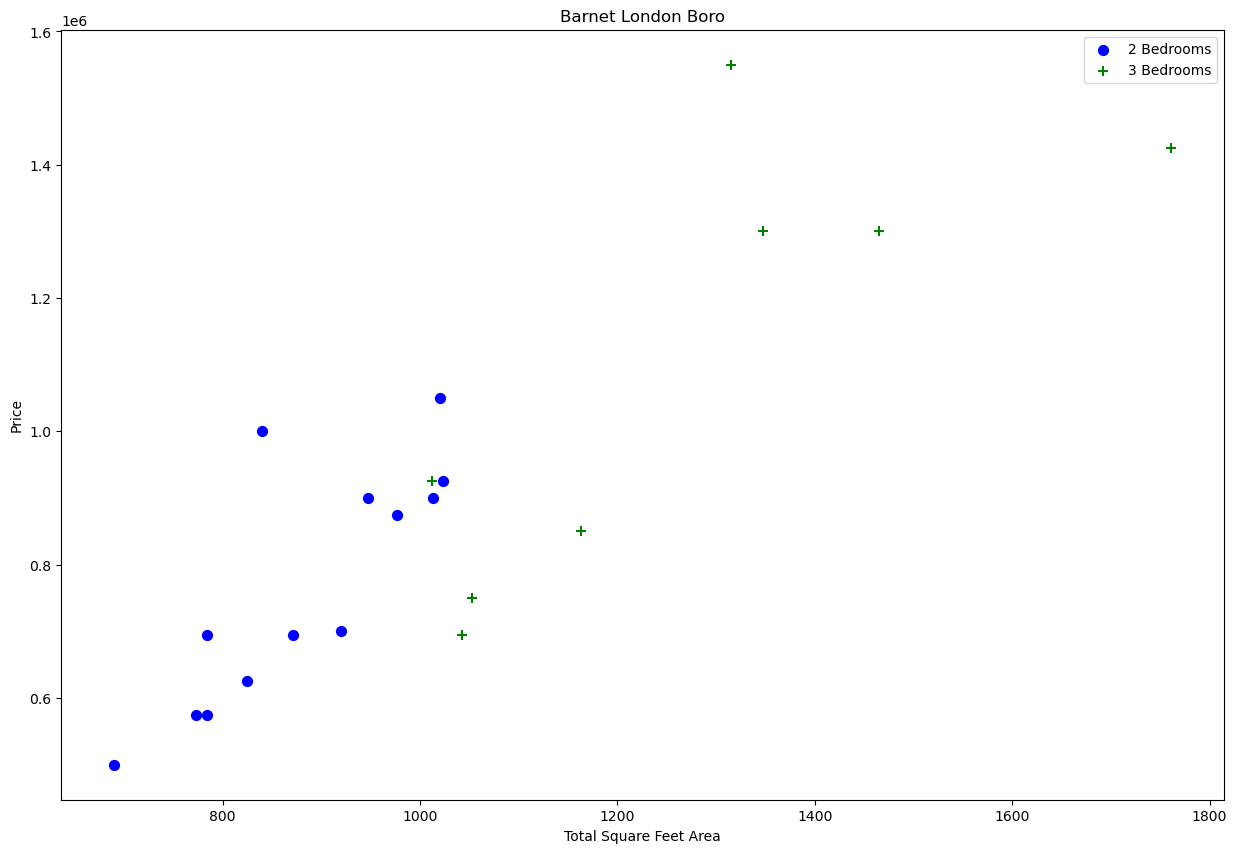

In [21]:
def plot_scatter_chart(df, location):
    bhk2 = df[(df.Location == location) & (df.Bedrooms == 2)]
    bhk3 = df[(df.Location == location) & (df.Bedrooms == 3)]
    plt.rcParams['figure.figsize'] = (15, 10)
    plt.scatter(bhk2.Total_sqft, bhk2.Price, color = 'blue', label = '2 Bedrooms', s=50)
    plt.scatter(bhk3.Total_sqft, bhk3.Price, marker = '+', color = 'green', label = '3 Bedrooms', s=50)
    plt.xlabel('Total Square Feet Area')
    plt.ylabel('Price')
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df4, 'Barnet London Boro')

In [16]:
def remove_bhk_outliers(df):
    """This function groups the houses in each location according to their bedroom numbers, 
       calculates the mean price_per_square foot for each bedroom number in each location and then removes
       anomalies by comparing the price per square foot for houses with mean of the houses with a lower bedroom count
       If the price per square foot of the house is lower than the mean of the lower bedroom count houses it would then be removed"""
    
    exclude_indices = np.array([])
    for location, location_df in df.groupby('Location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('Bedrooms'):
            bhk_stats[bhk] = {
                'mean' : np.mean(bhk_df.Price_per_sqft),
                'std'  : np.std(bhk_df.Price_per_sqft),
                'count' : bhk_df.shape[0]
            }
            
        for bhk, bhk_df in location_df.groupby('Bedrooms'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.Price_per_sqft < (stats['mean'])].index.values)
    return df.drop(exclude_indices, axis = 'index')

df5 = remove_bhk_outliers(df4)
df5.shape

(1567, 8)

In [17]:
def dummify(df):
    """This function loops through the features of the dataset and converts all Object features 
       into dummies"""
    objects = df.select_dtypes(include = 'object')
    new_df = df.copy()
    for i in objects.columns:
        dummies = pd.get_dummies(df[i])
        new_df = pd.concat([new_df.drop(i, axis = 'columns'), dummies], axis = 'columns')
        new_df = new_df[new_df.columns[:-1]]
        
    return new_df

In [18]:
df6 = dummify(df4)
df6

,Price,Total_sqft,Bedrooms,Baths,Receptions,Price_per_sqft,Bungalow,Duplex,Flat / Apartment,House,...,Newham London Boro,North East Derbyshire District,Redbridge London Boro,Richmond upon Thames London Boro,Sheffield District (B),Southwark London Boro,The City of Brighton and Hove (B),Three Rivers District,Tower Hamlets London Boro,Wandsworth London Boro
0,420000,403,1,1,1,1042.183623,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1735000,2118,4,4,4,819.169027,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2350000,2297,5,5,5,1023.073574,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1200000,1351,4,4,4,888.230940,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,575000,773,2,2,2,743.855110,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,995000,1762,4,4,4,564.699205,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2553,807995,1650,5,5,5,489.693939,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2554,2150000,2453,4,4,4,876.477782,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2555,2000000,2421,4,4,4,826.104915,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Splitting data

In [19]:
X = df6.drop("Price", axis = 1)
X.head()

,Total_sqft,Bedrooms,Baths,Receptions,Price_per_sqft,Bungalow,Duplex,Flat / Apartment,House,Mews,...,Newham London Boro,North East Derbyshire District,Redbridge London Boro,Richmond upon Thames London Boro,Sheffield District (B),Southwark London Boro,The City of Brighton and Hove (B),Three Rivers District,Tower Hamlets London Boro,Wandsworth London Boro
0,403,1,1,1,1042.183623,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2118,4,4,4,819.169027,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2297,5,5,5,1023.073574,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1351,4,4,4,888.230940,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,773,2,2,2,743.855110,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
y = df6.Price
y.head()

0     420000
1    1735000
2    2350000
3    1200000
4     575000
Name: Price, dtype: int64

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Modelling and Experimentation

In [37]:
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.8808707995834685

In [38]:
# Creating randomized splits of data
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 42)

# Scoring the model on the splits
cross_val_score(lr_clf, X, y, cv = cv)

array([0.8808708 , 0.80527076, 0.87378939, 0.89103442, 0.89144922])

### GridSearchCV

In [22]:
def gridsearch_models(X,y):
    '''This model brute forces through combinations of metrics for each of the models, fits them and 
       scores the models on randomized splits of data'''
    
    algorithms = {
        'linear_regression' : {
            'model' : LinearRegression(),
            'params' : {
                'fit_intercept' : [True, False],
                'positive' : [True, False]
            }
        },
        'lasso':{
            'model' : Lasso(),
            'params' : {
                'alpha' : [1, 2],
                'selection' : ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                    'criterion': ['squared_error', 'friedman_mse'],
                    'splitter': ['best', 'random']
                    
                }
    
        },
        'random_forest_regressor' : {
            'model': RandomForestRegressor(),
            'params': {
                'bootstrap': [True],
                'max_depth': [80, 90, 100, 110],
                'max_features': ['auto', 'sqrt'],
                'min_samples_leaf': [3, 4, 5],
                'min_samples_split': [8, 10, 12],
                'n_estimators': [100, 300, 400, 1000]
                }
        }
    }
    
    scores = []
    cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state=0)
    for algo_name, config in algorithms.items():
        gs = GridSearchCV(config['model'], config['params'], cv = cv, return_train_score = False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
        
    return pd.DataFrame(scores, columns=['model','best_score','best_params'])


In [37]:
gridsearch_models(X,y)

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.757e+14, tolerance: 4.902e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.935e+14, tolerance: 5.954e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

,model,best_score,best_params
0,linear_regression,0.865178,"{'fit_intercept': True, 'positive': True}"
1,lasso,0.869637,"{'alpha': 2, 'selection': 'cyclic'}"
2,decision_tree,0.957544,"{'criterion': 'squared_error', 'splitter': 'be..."
3,random_forest_regressor,0.952119,"{'bootstrap': True, 'max_depth': 80, 'max_feat..."


In [23]:
scores = gridsearch_models(X,y)

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.823e+14, tolerance: 5.872e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.025e+14, tolerance: 4.902e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

In [24]:
scores

,model,best_score,best_params
0,linear_regression,0.865178,"{'fit_intercept': True, 'positive': True}"
1,lasso,0.869639,"{'alpha': 2, 'selection': 'random'}"
2,decision_tree,0.942340,"{'criterion': 'squared_error', 'splitter': 'be..."
3,random_forest_regressor,0.953212,"{'bootstrap': True, 'max_depth': 90, 'max_feat..."


In [26]:
random_forest = RandomForestRegressor(bootstrap = True, max_depth = 100, max_features = 'auto', min_samples_leaf = 3, 
                                     min_samples_split = 8, n_estimators = 300)

In [39]:
# Fitting Random Forest 
random_forest.fit(X,y)

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(max_depth=100, max_features='auto', min_samples_leaf=3,
                      min_samples_split=8, n_estimators=300)

Amongst the models, Random Forest Tree Regressor had the most accuracy

In [41]:
df6.head()

,Price,Total_sqft,Bedrooms,Baths,Receptions,Price_per_sqft,Bungalow,Duplex,Flat / Apartment,House,...,Newham London Boro,North East Derbyshire District,Redbridge London Boro,Richmond upon Thames London Boro,Sheffield District (B),Southwark London Boro,The City of Brighton and Hove (B),Three Rivers District,Tower Hamlets London Boro,Wandsworth London Boro
0,420000,403,1,1,1,1042.183623,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1735000,2118,4,4,4,819.169027,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2350000,2297,5,5,5,1023.073574,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1200000,1351,4,4,4,888.230940,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,575000,773,2,2,2,743.855110,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
def predict_price_random(location, sqft,baths,bedrooms,receptions,house_type):
    """This function outputs a prediction price for Random Forest from custom house features entered as input
       through arguments"""
    loc_index = np.where(X.columns==location)[0][0]
    loc_index2 = np.where(X.columns == house_type)[0][0]
    
    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bedrooms
    x[2] = baths
    x[3] = receptions
    x[loc_index] = 1
    x[loc_index2] = 1
        
    return random_forest.predict([x])[0], loc_index, loc_index2

In [34]:
def predict_price(location, sqft,baths,bedrooms,receptions,house_type):
    """This function outputs a prediction price for Decision Tree from custom house features entered as input
       through arguments"""
    loc_index = np.where(X.columns==location)[0][0]
    loc_index2 = np.where(X.columns == house_type)[0][0]
    
    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bedrooms
    x[2] = baths
    x[3] = receptions
    x[loc_index] = 1
    x[loc_index2] = 1
        
    return decision_tree.predict([x])[0], loc_index, loc_index2
    

In [30]:
# Intializing Decision Tree Regressor with the best parameters found in GridSearch
decision_tree = DecisionTreeRegressor(criterion = 'friedman_mse', splitter= 'best')

In [31]:
# Fitting decision tree
decision_tree.fit(X.values, y.values)

DecisionTreeRegressor(criterion='friedman_mse')

Since the accuracies of Random Forest Regressor and Decision Tree were close, further experimentation between the two models had to be done to make sure Random Forest was the best one.

In [27]:
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 41)

np.mean(cross_val_score(random_forest, X, y, cv = cv))

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

0.9601722799268526

In [32]:
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 41)

cross_val_score(decision_tree, X, y, cv = cv)

array([0.97883704, 0.96903692, 0.87218684, 0.98046127, 0.84830846])

In [35]:
predict_price("Haringey London Boro", 2300, 1, 2, 4, 'House')

(1150000.0, 27, 8)

In [40]:
predict_price_random("Haringey London Boro",2300, 1, 2, 4, 'House')

C:\Users\meeta\anaconda3\envs\pytorch_attempt\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


(1129197.9076805608, 27, 8)

In [ ]:
# Saving the model 
import pickle
with open('london_home_prices_model.pickle', 'wb') as f:
    pickle.dump(random_forest, f)

In [263]:
# Saving the dataset columns for use in the backend operations of the website to be created
import json 
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open('columns.json', 'w') as f:
    f.write(json.dumps(columns))

## Model Explainability 

__After testing out the models' outputs when fed in different variations of the features, it was discovered that the output price of the houses would only change when the Total_sqft was altered in the Decision Tree. The other features of the dataset would not change the outcome of house prices for the model. 
To see the reason for this, coefficients for all the features per model were investigated__

In [76]:
def evaluation_metrics(model):
    """This function fits a model, makes predictions on test data, prints out the coefficient scores for each feature
       and finds the metrics of the models according to R2 score, MSE and MAE"""
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    coefficients = model.coef_
    print("Feature names and their importances:")
    for feature_name, coefficient in zip(X_train.columns, coefficients):
        print(f"{feature_name}: {coefficient}")
    print(f"The R2 score of this model is: {r2_score(y_true = y_test, y_pred = preds)}")
    print(f"The Mean Squared Error of this model is: {mean_squared_error(y_true = y_test, y_pred = preds)}")
    print(f"The Mean Absolute Error of this model is: {mean_absolute_error(y_true=y_test, y_pred=preds)}")

In [74]:
def evaluation_metrics_decision(model):
    """This function fits the decision tree, makes predictions on test data, prints out the coefficient scores for each feature
       and finds the metrics of the model according to R2 score, MSE and MAE"""
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    importances = model.feature_importances_
    print("Feature names and their coefficients:")
    for feature_name, importance in zip(X_train.columns, importances):
        print(f"{feature_name}: {importance}")
    print(f"The R2 score of this model is: {r2_score(y_true = y_test, y_pred = preds)}")
    print(f"The Mean Squared Error of this model is: {mean_squared_error(y_true = y_test, y_pred = preds)}")
    print(f"The Mean Absolute Error of this model is: {mean_absolute_error(y_true=y_test, y_pred=preds)}")

In [69]:
evaluation_metrics(LinearRegression())

Feature names and their coefficients:
Total_sqft: 1067.3802729406912
Bedrooms: -1810818759767580.0
Baths: 2373668260103154.0
Receptions: -562849500381805.9
Price_per_sqft: 2114.5
Bungalow: 269358.71575927734
Duplex: 60718.10501098633
Flat / Apartment: -69011.8125
House: 95488.9921875
Mews: 128266.60167884827
New development: -123929.798828125
Penthouse: -59368.72814941406
Barnet London Boro: -85577.90716552734
Brent London Boro: -38825.51190185547
Camden London Boro: -180266.20458984375
Cheshire East (B): -377343.95916748047
Cheshire West and Chester (B): -196807.82369995117
City and County of the City of London: -666293.4184570312
City of Westminster London Boro: -212258.31079101562
Doncaster District (B): 7958.2786865234375
Ealing London Boro: 11340.054504394531
Elmbridge District (B): -1033299.98046875
Enfield London Boro: -109224.5908203125
Epping Forest District: -400435.1882324219
Greenwich London Boro: 38431.44305419922
Hackney London Boro: 56323.7216796875
Hammersmith and Fulha

In [70]:
evaluation_metrics(Lasso())

Feature names and their coefficients:
Total_sqft: 1067.8091236769606
Bedrooms: -46670.39909929225
Baths: -1.7286606897632378e-11
Receptions: -3.1430194359331597e-12
Price_per_sqft: 2114.6534708813683
Bungalow: 268430.9273507085
Duplex: 59776.64153727948
Flat / Apartment: -69276.84804528358
House: 95089.00647143267
Mews: 126325.73602825144
New development: -124229.46919289071
Penthouse: -59632.800179073616
Barnet London Boro: -84846.65050232231
Brent London Boro: -37960.07993073547
Camden London Boro: -179514.66235167917
Cheshire East (B): -376464.8589765653
Cheshire West and Chester (B): -196069.70724504776
City and County of the City of London: -665340.3971045429
City of Westminster London Boro: -211407.8299580896
Doncaster District (B): 8452.664204363362
Ealing London Boro: 11932.1611036323
Elmbridge District (B): -1032821.8758936267
Enfield London Boro: -108520.11653522884
Epping Forest District: -399871.72887801065
Greenwich London Boro: 38833.19101852464
Hackney London Boro: 56918

D:\Anaconda\envs\pytorch_attempt\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.458e+13, tolerance: 5.821e+11
  model = cd_fast.enet_coordinate_descent(


In [77]:
evaluation_metrics_decision(DecisionTreeRegressor())

Feature names and their coefficients:
Total_sqft: 0.6653467877757268
Bedrooms: 0.0010254932027184286
Baths: 0.004537646576235665
Receptions: 0.00012484085391168036
Price_per_sqft: 0.32805521616899314
Bungalow: 0.0
Duplex: 8.016832689724565e-08
Flat / Apartment: 1.492139897952558e-05
House: 5.345783351639624e-05
Mews: 2.5983127378462317e-07
New development: 1.010327430349951e-05
Penthouse: 3.3641707857405055e-05
Barnet London Boro: 2.4007260356022487e-06
Brent London Boro: 1.6301677094854688e-06
Camden London Boro: 5.304882298921678e-05
Cheshire East (B): 1.4652359396534158e-06
Cheshire West and Chester (B): 1.8644865175945077e-06
City and County of the City of London: 2.8273221754260924e-07
City of Westminster London Boro: 5.216386609300491e-05
Doncaster District (B): 6.721255264015458e-08
Ealing London Boro: 5.710561284738857e-06
Elmbridge District (B): 3.0273649695328552e-05
Enfield London Boro: 1.556124488178997e-08
Epping Forest District: 4.120372844976925e-06
Greenwich London Boro

<Axes: >

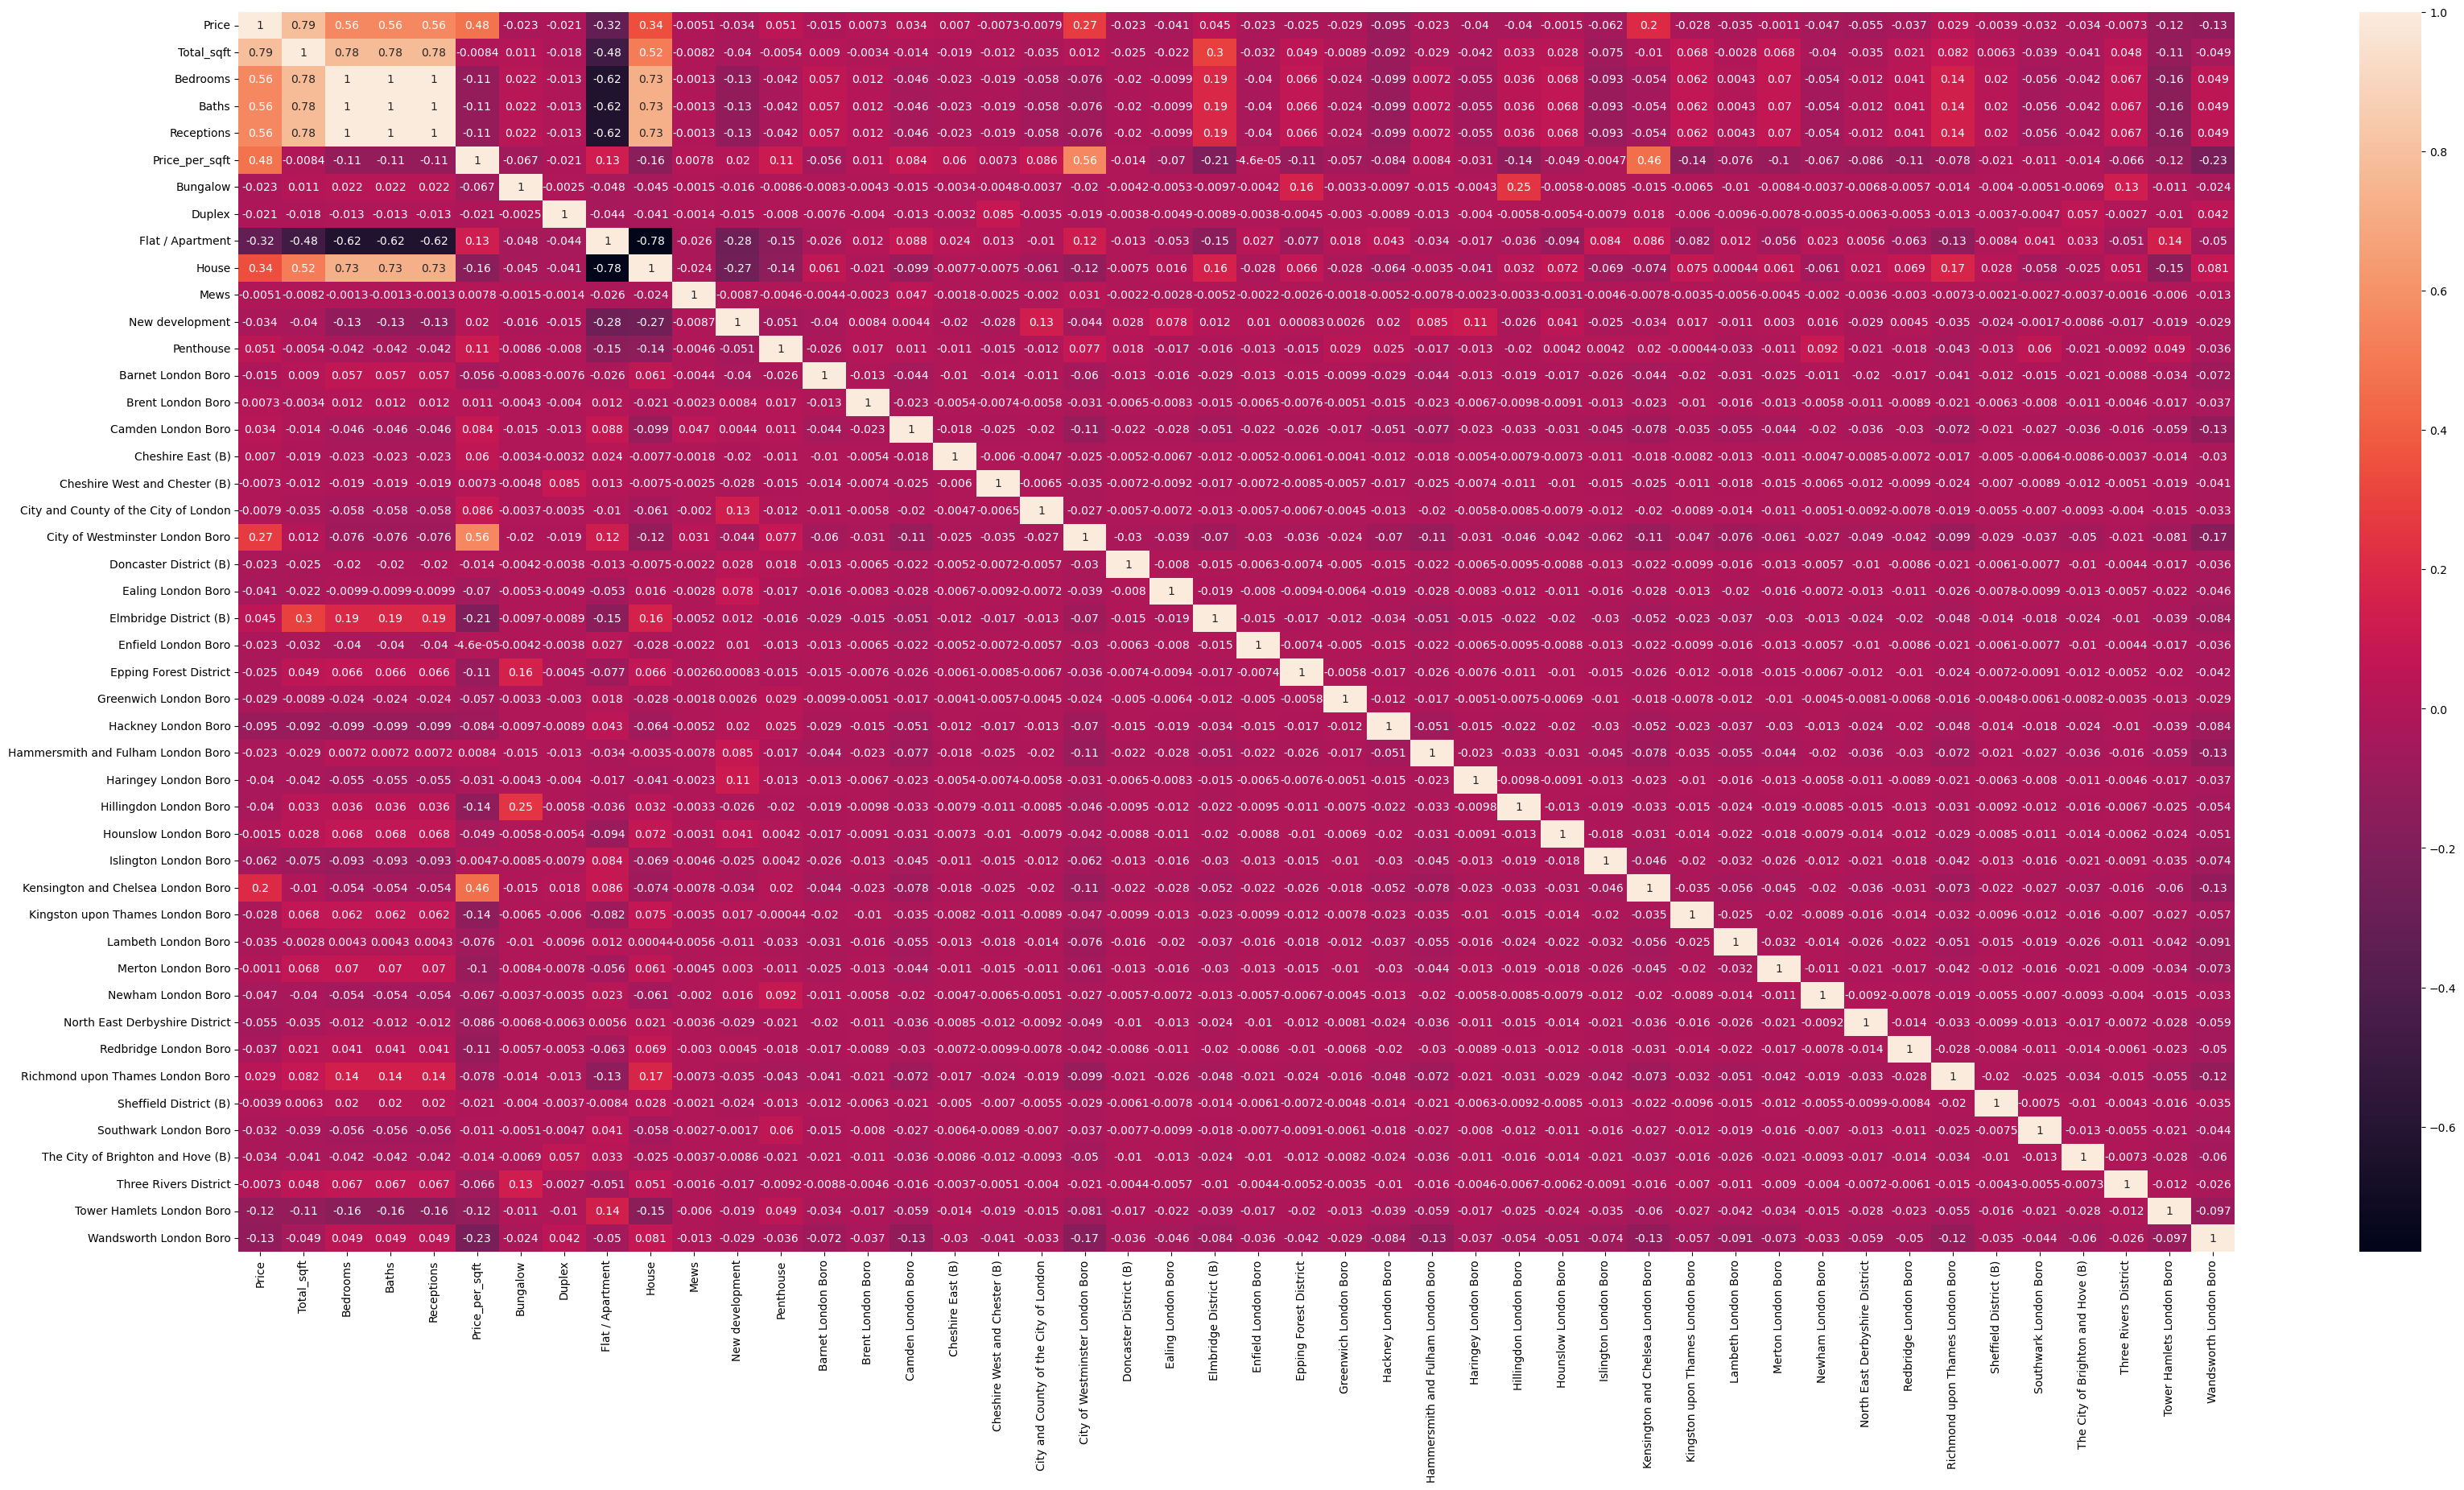

In [26]:
plt.figure(figsize = (40, 20))
sns.heatmap(df6.corr(), annot = True)

- __From the results of the coefficients and feature importances above, it can be seen that the feature which had the best coefficient and most significant feature importance was Total_sqft.__ <br>
- __The other features of the dataset had no significance to the Decision Tree model indicating that they were not being used for any predictions. This indicated that the model was overfitting on the Total_sqft feature and not using the other features__<br>
- __The Random Forest Regressor had its predictions changing when more of its features were varied indicating that it had not overfit on Total_sqft__
- __This then led to Random Forest Regressor being used as the final model__

## Conclusion

The Random Forest Regressor did the best job predicting the prices of the houses without overfitting on a single feature like the Decision Tree model.
Even though locations of the houses did not end up being used because of low correlation with house prices, the other features of the houses aided in 
the prediction of the prices in the Random Forest Tree Regressor.